# 1. Data Loading and Overview

In [255]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, BaseCrossValidator, PredefinedSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

plt.style.use("ggplot")
sns.set_palette("deep")
SEED = 42

train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

train.Date = pd.to_datetime(train.Date)
train = train.sort_values("Date")

C:\Users\mrdow\AppData\Local\Temp\ipykernel_61044\2309231344.py:21: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")


In [256]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017208,1115,2,2013-01-01,0,0,0,0,a,1
1016473,379,2,2013-01-01,0,0,0,0,a,1
1016472,378,2,2013-01-01,0,0,0,0,a,1
1016471,377,2,2013-01-01,0,0,0,0,a,1
1016470,376,2,2013-01-01,0,0,0,0,a,1


In [257]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017209 entries, 1017208 to 0
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 77.6+ MB


In [258]:
print(train.isna().sum())
print('----------------')
print(train.duplicated().sum(), "duplicates")

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
----------------
0 duplicates


In [259]:
train.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846062080,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01


In [260]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [261]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [262]:
print(store.isna().sum())
print('----------------')
print(store.duplicated().sum(), "duplicates")

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64
----------------
0 duplicates


In [263]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


# 2. Exploratory Data Analysis (EDA)

In [264]:
store[store.CompetitionDistance.isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


##### *Since we are missing values for CompetitionDistance, we can assume there is no competition*

In [265]:
# Merging store information with sales data for analysis.
df = train.merge(store, on="Store")

# Extracting time features for analysis
df["Year"] = df.Date.dt.year
df["Month"] = df.Date.dt.month
df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)

# Adding 'sales_per_customer' feature to provide a clearer view of the sales.
df["sales_per_customer"] = df["Sales"] / df["Customers"]
df["sales_per_customer"] = df["sales_per_customer"].fillna(0)

print(df.isna().sum())

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Year                              0
Month                             0
WeekOfYear                        0
sales_per_customer                0
dtype: int64


In [266]:
df.SchoolHoliday.value_counts()

SchoolHoliday
0    835488
1    181721
Name: count, dtype: int64

In [267]:
df.StateHoliday.value_counts()

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [268]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,sales_per_customer
0,1115,2,2013-01-01,0,0,0,0,a,1,d,...,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,0.0
1,379,2,2013-01-01,0,0,0,0,a,1,d,...,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,0.0
2,378,2,2013-01-01,0,0,0,0,a,1,a,...,8.0,2012.0,0,NaN,NaN,NaN,2013,1,1,0.0
3,377,2,2013-01-01,0,0,0,0,a,1,a,...,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",2013,1,1,0.0
4,376,2,2013-01-01,0,0,0,0,a,1,a,...,8.0,2012.0,0,NaN,NaN,NaN,2013,1,1,0.0


##### *mixed data types we will fix later*

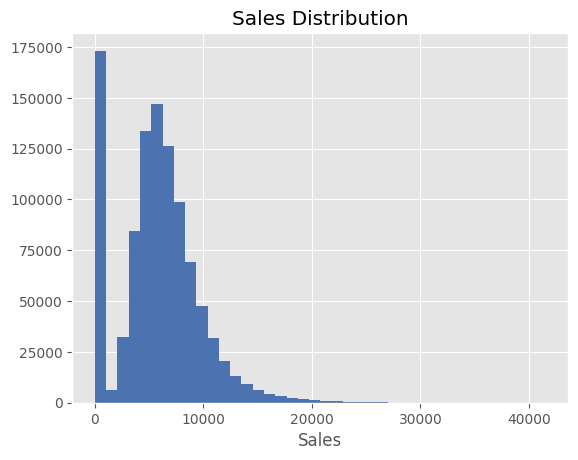

In [269]:
plt.hist(df.Sales, bins=40)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.show()

##### *In the Sales Distribution plot, we can see that the sales data is highly skewed, with many values at zero.*

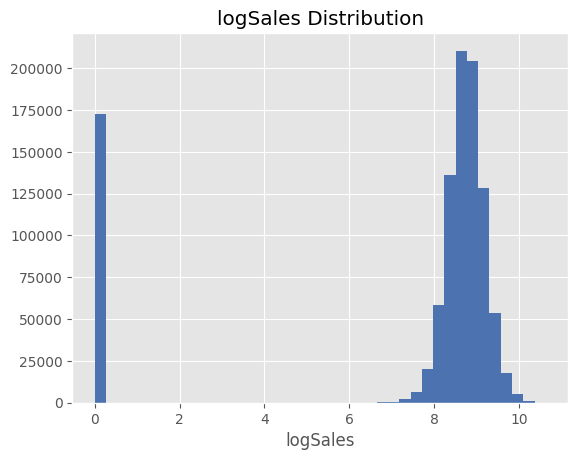

In [270]:
df["log_sales"] = np.log1p(df.Sales)

plt.hist(df.log_sales, bins=40)
plt.title("logSales Distribution")
plt.xlabel("logSales")
plt.show()

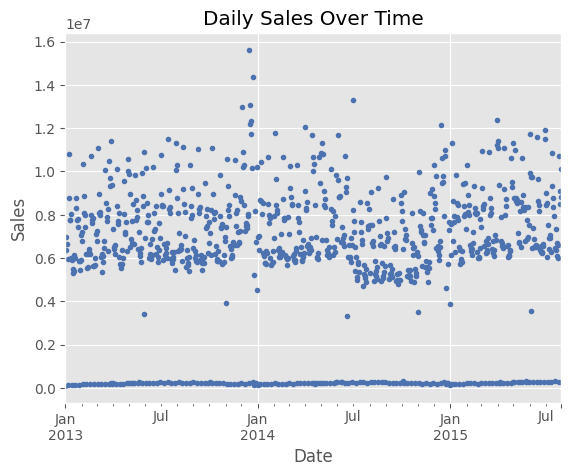

In [271]:
df.groupby("Date")["Sales"].sum().plot(style=".")
plt.title("Daily Sales Over Time")
plt.ylabel("Sales")
plt.show()

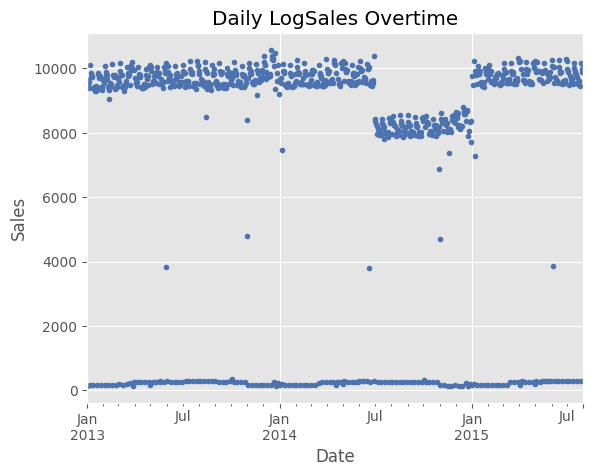

In [272]:
df.groupby("Date")["log_sales"].sum().plot(style=".")
plt.title("Daily LogSales Overtime")
plt.ylabel("Sales")
plt.show()

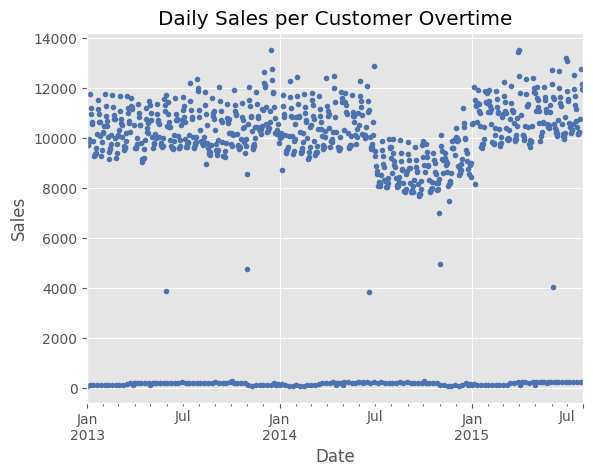

In [273]:
df.groupby("Date")["sales_per_customer"].sum().plot(style=".")
plt.title("Daily Sales per Customer Overtime")
plt.ylabel("Sales")
plt.show()

##### *We can see in the plot that overall sales dropped significantly from July 2014 to January 2015.*
##### *We also observe some unusual values in the middle of the distribution.*

In [274]:
# Filtering the period where sales were declining
declining_sales = df[(df.Date > "2014-07-01") & (df.Date < "2015-01-01")]
declining_sales.shape

(171105, 23)

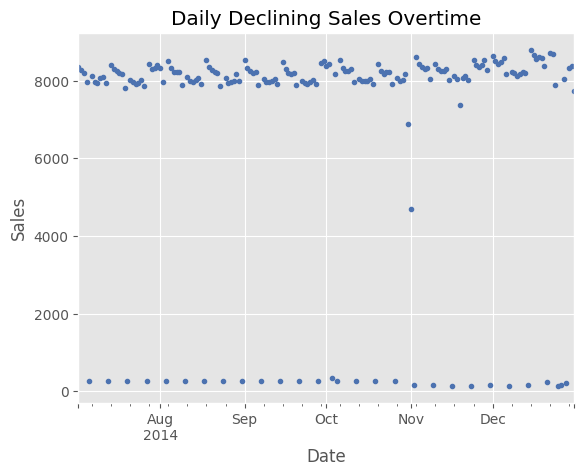

In [275]:
declining_sales.groupby("Date")["log_sales"].sum().plot(style=".")
plt.title("Daily Declining Sales Overtime")
plt.ylabel("Sales")
plt.show()

###### *I found in internet in this time period Poland had economical deflation and weak external trades caused by several factors.*
###### *We can also see a monthly pattern in sales.*

In [276]:
# comparing promotion intensity between declining and stable period
stable_sales = df[~df.Date.isin(declining_sales.Date)]

print(((declining_sales.Promo == 1).sum() + (declining_sales.Promo2 == 1).sum()) / len(declining_sales) * 100, "% declining sales promo intensity")
print(((stable_sales.Promo == 1).sum() + (stable_sales.Promo2 == 1).sum()) / len(stable_sales) * 100, "% stable sales promo intensity")

84.27573712048158 % declining sales promo intensity
89.00300672257784 % stable sales promo intensity


##### A 4.8 % lower promotion intensity might have caused the sales drop during the declining period

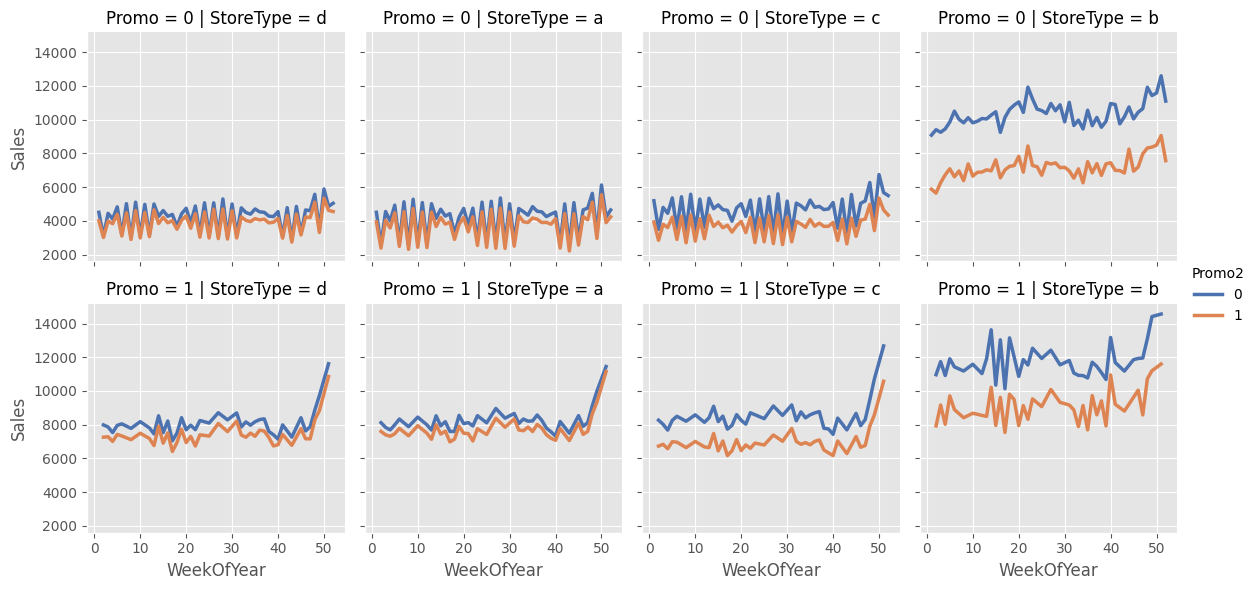

In [277]:
g = sns.FacetGrid(df, col="StoreType", row="Promo", hue="Promo2")
g.map(sns.lineplot, "WeekOfYear", "Sales", errorbar=None, linewidth=2.5)
g.add_legend()
plt.show()

#### *Sales dropped significantly when Promo2 was active.*

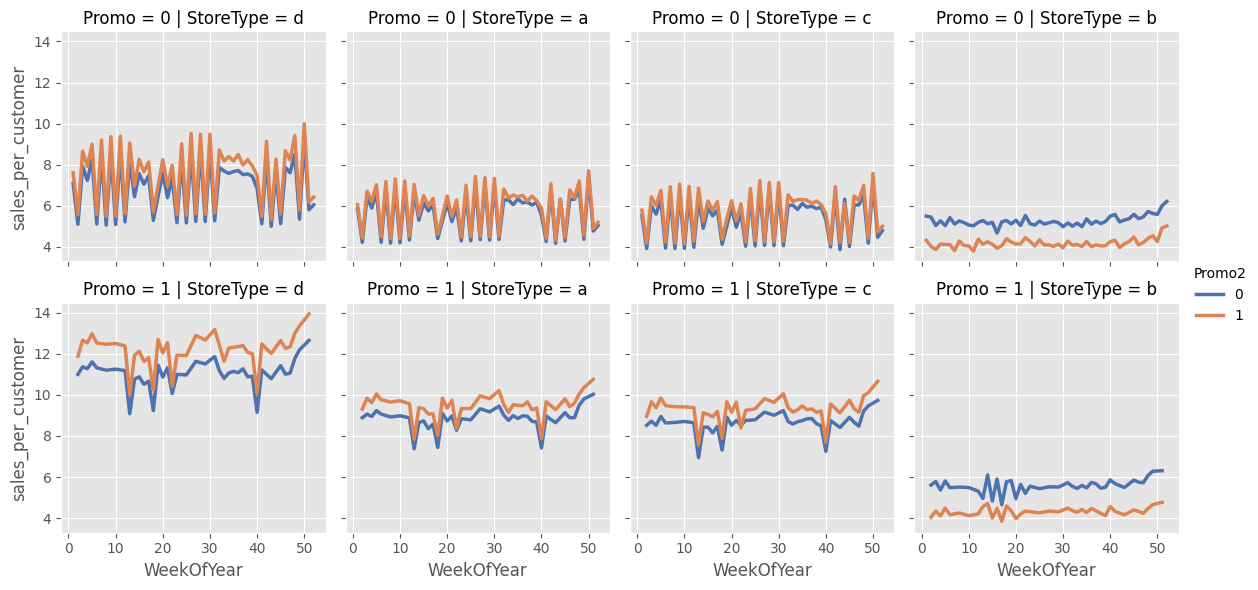

In [278]:
g = sns.FacetGrid(df, col="StoreType", row="Promo", hue="Promo2")
g.map(sns.lineplot, "WeekOfYear", "sales_per_customer", errorbar=None, linewidth=2.5)
g.add_legend()
plt.show()

##### *Promo2 is positively affecting sales per customer for StoreType A, C and D.*
##### *Stopping Promo2 for StoreType B could help save costs.*

In [279]:
df[df.Open == 0]["Sales"].sum()

np.int64(0)

##### *Normally, closed stores shouldn't impact sales since they have no sales,*
##### *but we need to verify this by checking the CV score.*
##### *These rows might still contain valuable information.*

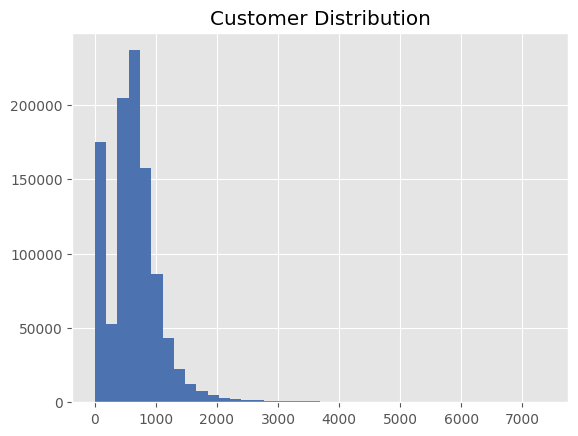

In [280]:
plt.hist(df.Customers, bins=40)
plt.title("Customer Distribution")
plt.show()

In [281]:
df.sort_values("Customers", ascending=False).head(20)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,sales_per_customer,log_sales
24455,817,2,2013-01-22,27190,7388,1,1,0,0,a,...,2006.0,0,NaN,NaN,NaN,2013,1,4,3.680292,10.210641
697075,262,5,2014-10-03,35702,5494,1,1,a,0,b,...,2013.0,0,NaN,NaN,NaN,2014,10,40,6.498362,10.482990
915095,262,5,2015-05-01,38484,5458,1,1,a,0,b,...,2013.0,0,NaN,NaN,NaN,2015,5,18,7.050934,10.558024
584727,262,1,2014-06-09,34692,5387,1,0,a,0,b,...,2013.0,0,NaN,NaN,NaN,2014,6,24,6.439948,10.454293
572462,262,4,2014-05-29,37403,5297,1,0,a,0,b,...,2013.0,0,NaN,NaN,NaN,2014,5,22,7.061167,10.529533
929592,262,4,2015-05-14,38367,5192,1,0,a,1,b,...,2013.0,0,NaN,NaN,NaN,2015,5,20,7.389638,10.554979
887223,262,1,2015-04-06,33655,5152,1,0,b,0,b,...,2013.0,0,NaN,NaN,NaN,2015,4,15,6.532415,10.423947
271412,262,7,2013-09-01,32926,5145,1,0,0,0,b,...,2013.0,0,NaN,NaN,NaN,2013,9,35,6.399611,10.402048
883876,262,5,2015-04-03,38722,5132,1,1,b,0,b,...,2013.0,0,NaN,NaN,NaN,2015,4,14,7.545207,10.564189
240193,262,7,2013-08-04,32252,5112,1,0,0,0,b,...,2013.0,0,NaN,NaN,NaN,2013,8,31,6.309077,10.381366


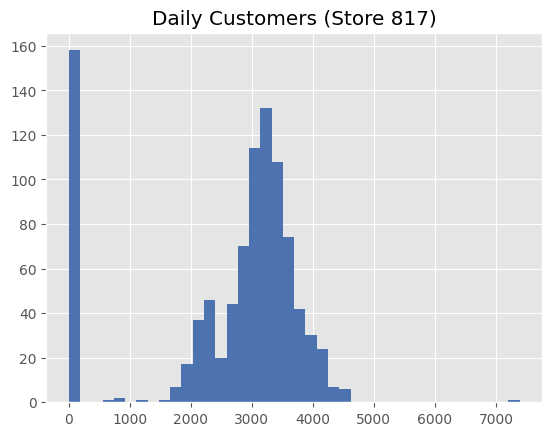

In [282]:
store_817 = df[df["Store"]==817]
plt.hist(store_817.Customers, bins=40)
plt.title("Daily Customers (Store 817)")
plt.show()

##### *We can see that for Store 817, 7388 customers isn’t common.*

In [283]:
store_817.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,WeekOfYear,sales_per_customer,log_sales
count,942.0,942.000000,942,942.000000,942.000000,942.000000,942.000000,942.000000,942.0,942.0,942.0,942.0,0.0,0.0,942.000000,942.000000,942.000000,942.000000,942.000000
mean,817.0,3.997877,2014-04-16 12:00:00,18108.139066,2605.488323,0.832272,0.382166,0.183652,140.0,3.0,2006.0,0.0,NaN,NaN,2013.837580,5.961783,24.098726,5.772604,8.291403
min,817.0,1.000000,2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,140.0,3.0,2006.0,0.0,NaN,NaN,2013.000000,1.000000,1.000000,0.000000,0.000000
25%,817.0,2.000000,2013-08-24 06:00:00,14853.500000,2235.250000,1.000000,0.000000,0.000000,140.0,3.0,2006.0,0.0,NaN,NaN,2013.000000,3.000000,12.000000,6.335963,9.606055
50%,817.0,4.000000,2014-04-16 12:00:00,20914.000000,3069.500000,1.000000,0.000000,0.000000,140.0,3.0,2006.0,0.0,NaN,NaN,2014.000000,6.000000,23.000000,6.759797,9.948221
75%,817.0,6.000000,2014-12-07 18:00:00,23897.250000,3416.500000,1.000000,1.000000,0.000000,140.0,3.0,2006.0,0.0,NaN,NaN,2014.000000,9.000000,36.000000,7.177805,10.081561
max,817.0,7.000000,2015-07-31 00:00:00,38025.000000,7388.000000,1.000000,1.000000,1.000000,140.0,3.0,2006.0,0.0,NaN,NaN,2015.000000,12.000000,52.000000,8.683681,10.546025
std,0.0,1.998404,NaN,9183.542868,1290.924669,0.373823,0.486175,0.387406,0.0,0.0,0.0,0.0,NaN,NaN,0.766009,3.350357,14.547508,2.637595,3.730243


##### *Since Store 817 mean sales_per_customer = 6.93 and a standard deviation = 0.53,*
##### *Row where customers = 7,388 and sales_per_customer = 3.68 is most likely isn't valid.*

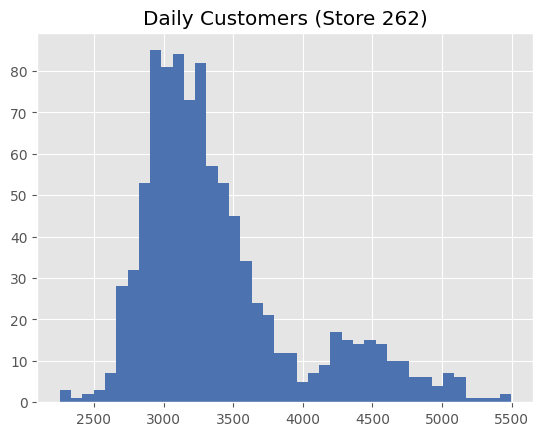

In [284]:
store_262 = df[df["Store"]==262]
plt.hist(store_262.Customers, bins=40)
plt.title("Daily Customers (Store 262)")
plt.show()

In [285]:
store_262.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,WeekOfYear,sales_per_customer,log_sales
count,942.0,942.000000,942,942.000000,942.000000,942.0,942.000000,942.000000,942.0,942.0,942.0,942.0,0.0,0.0,942.000000,942.000000,942.000000,942.000000,942.000000
mean,262.0,3.997877,2014-04-16 12:00:00,20718.515924,3402.010616,1.0,0.382166,0.179406,1180.0,5.0,2013.0,0.0,NaN,NaN,2013.837580,5.961783,24.098726,6.057073,9.916616
min,262.0,1.000000,2013-01-01 00:00:00,13210.000000,2255.000000,1.0,0.000000,0.000000,1180.0,5.0,2013.0,0.0,NaN,NaN,2013.000000,1.000000,1.000000,4.665957,9.488805
25%,262.0,2.000000,2013-08-24 06:00:00,17454.250000,3000.000000,1.0,0.000000,0.000000,1180.0,5.0,2013.0,0.0,NaN,NaN,2013.000000,3.000000,12.000000,5.678945,9.767396
50%,262.0,4.000000,2014-04-16 12:00:00,19415.500000,3239.000000,1.0,0.000000,0.000000,1180.0,5.0,2013.0,0.0,NaN,NaN,2014.000000,6.000000,23.000000,6.022902,9.873878
75%,262.0,6.000000,2014-12-07 18:00:00,22125.000000,3600.750000,1.0,1.000000,0.000000,1180.0,5.0,2013.0,0.0,NaN,NaN,2014.000000,9.000000,36.000000,6.458784,10.004509
max,262.0,7.000000,2015-07-31 00:00:00,38722.000000,5494.000000,1.0,1.000000,1.000000,1180.0,5.0,2013.0,0.0,NaN,NaN,2015.000000,12.000000,52.000000,7.602929,10.564189
std,0.0,1.998404,NaN,4668.877584,580.749234,0.0,0.486175,0.383895,0.0,0.0,0.0,0.0,NaN,NaN,0.766009,3.350357,14.547508,0.515688,0.204685


###### *Store 262 was never closed during the observed period.*

In [286]:
# Stores that open on Sundays
df[(df.Open == 1) & (df.DayOfWeek == 7)]["Store"].unique()

array([ 353,  310,  335,  494,  530,  423,   85,  274,  262,  259,  948,
        863, 1097,  682,  676,  578,  562,  769,  733,  512, 1045,  877,
       1099,  122,  209,  299,  524,  453,  732,  931,  867,  433, 1081])

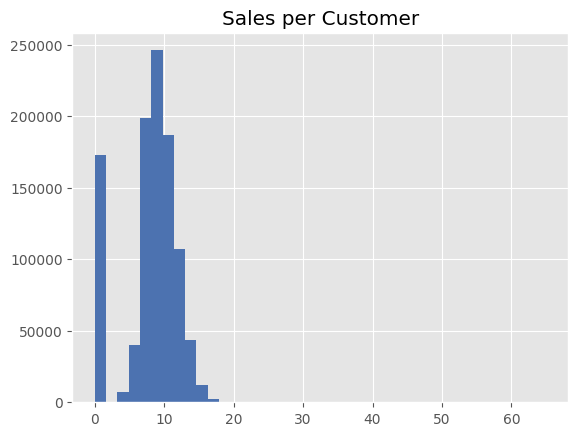

In [287]:
plt.hist(df.sales_per_customer, bins=40)
plt.title("Sales per Customer")
plt.show()

In [288]:
# filtering rows with extreme 'sales_per_customer' values for inspection
sales_pc_gt_20 = df[df.sales_per_customer > 20]
sales_pc_gt_20.shape

(90, 23)

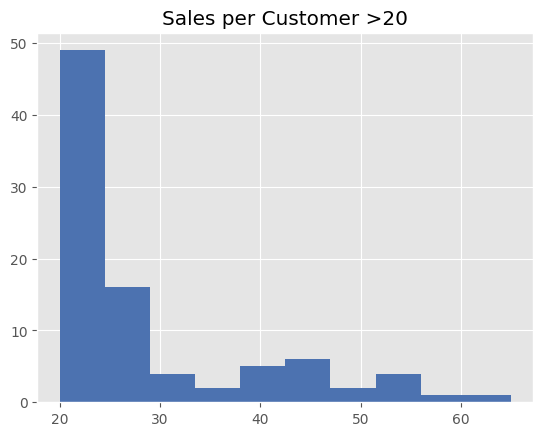

In [289]:
plt.hist(sales_pc_gt_20.sales_per_customer)
plt.title("Sales per Customer >20")
plt.show()

In [290]:
sales_pc_gt_20.Store.value_counts()

Store
126     30
897     12
985      6
956      6
548      6
612      4
937      3
13       3
803      3
1047     2
348      2
227      2
393      1
623      1
458      1
169      1
303      1
908      1
461      1
909      1
292      1
52       1
876      1
Name: count, dtype: int64

##### *Store 126 has noticeably more extreme 'sales_per_customer' values than the others*

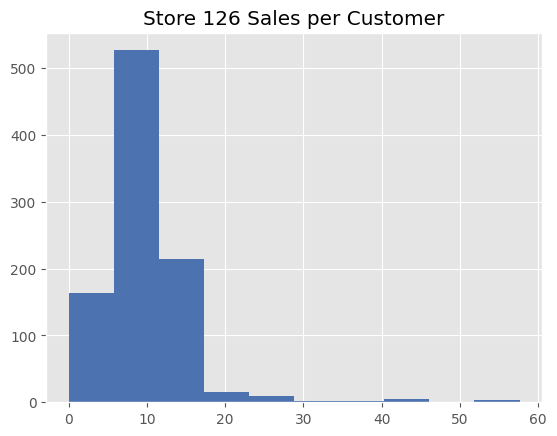

In [291]:
store_126 = df[df.Store == 126]
plt.hist(store_126.sales_per_customer)
plt.title("Store 126 Sales per Customer")
plt.show()

In [292]:
store_126[["Sales", "Customers", "sales_per_customer"]].describe()

,Sales,Customers,sales_per_customer
count,942.000000,942.000000,942.000000
mean,5381.677282,449.713376,9.765317
std,3708.827853,228.800134,6.181741
min,0.000000,0.000000,0.000000
25%,4068.750000,427.000000,9.373941
50%,5316.500000,504.000000,10.520227
75%,6993.500000,590.000000,11.599554
max,33071.000000,1078.000000,57.614983


#### *Observing uncommon values in sales per customer for store 126*

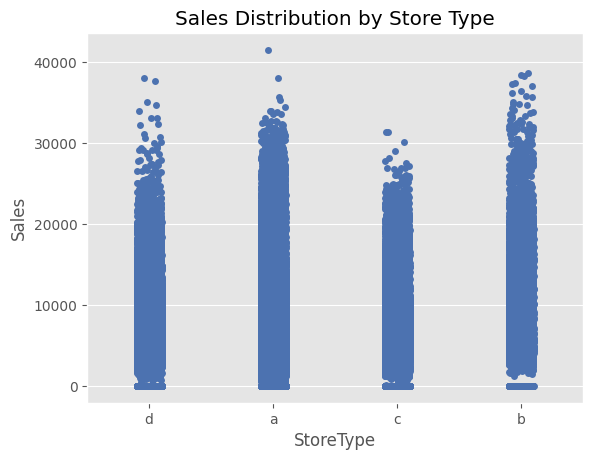

In [293]:
sns.stripplot(x="StoreType", y="Sales", data=df, jitter=True)
plt.title("Sales Distribution by Store Type")
plt.show()

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [295]:
corr = df.select_dtypes(include=["int", "float"]).corr()

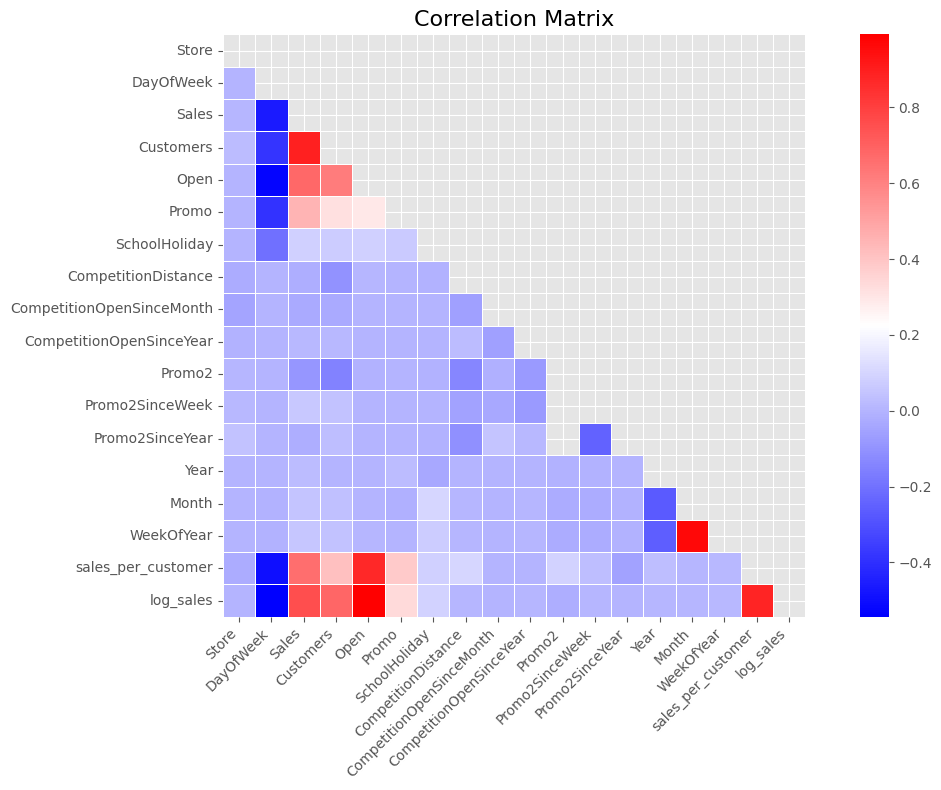

In [296]:
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    mask=mask,
    cmap="bwr",
    linewidths=0.5,
    square=True
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Cleaining

In [297]:
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Year                              0
Month                             0
WeekOfYear                        0
sales_per_customer                0
log_sales                         0
dtype: int64

In [298]:
# I decided to drop the uncommon values since there were only a few of them
# Doing so slightly improved the CV score during later testing
df = df[(df.log_sales <= 2) | (df.log_sales >= 6)]

# Replacing Customer outlier with the mean or median caused the CV score to drop in later testing,
# while dropping the raw entirely improved the score.
df = df[df.Customers < 7000]

# Removing the sales outlier lowered the score; replacing it with 0 improved it.
df.loc[df["Sales"] > 40000, "Sales"] = 0

In [299]:
df.CompetitionDistance = df.CompetitionDistance.fillna(0)

In [300]:
# Setting integer 0 to string "0" in 'StateHoliday' so that all values are strings
# Later, we'll preprocess this column to numeric form
df.StateHoliday = df.StateHoliday.apply(lambda x: "0" if x == 0 else x)
df.StateHoliday.value_counts()

StateHoliday
0    986152
a     20260
b      6690
c      4100
Name: count, dtype: int64

# 4. Engineering Pipeline

In [301]:
# Calculating how long each store's competitions and promotion has been open (in months)
df["competition_open"] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
df["PromoOpen"] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) / 4

In [302]:
# Adding time-based features

# Encode weekly cycle using sine and cosine to capture day-of-week patterns
df["dow_sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 7)

df["is_weekend"] = df["DayOfWeek"].isin([6, 7]).astype(int)

df["lag1"] = df["Sales"].shift(1)
df["lag7"] = df["Sales"].shift(7)

df["rolling_3"] = df["Sales"].shift(1).rolling(window=3).mean()
df["rolling_7"] = df["Sales"].shift(1).rolling(window=7).mean()

df["diff1"] = df["Sales"].diff(1)
df["diff7"] = df["Sales"].diff(7)

In [303]:
X = df.drop(["Date", "log_sales", "sales_per_customer", "CompetitionOpenSinceYear", "CompetitionOpenSinceMonth"], axis=1)
# Changed y to its square root to stabilize variance and reduce heteroscedasticity observed in the residual plots
y = np.sqrt(X.pop("Sales"))

cat_cols = X.select_dtypes(include=["object"])
for col in cat_cols:
    X[col] = X[col].astype("category")

cat_cols.head()

,StateHoliday,StoreType,Assortment,PromoInterval
0,a,d,c,"Mar,Jun,Sept,Dec"
1,a,d,a,NaN
2,a,a,c,NaN
3,a,a,c,"Feb,May,Aug,Nov"
4,a,a,a,NaN


# 5. Train Test Split

In [304]:
unique_dates = df.Date.sort_values().unique()
split_point = int(len(unique_dates)*0.8)

train_dates = unique_dates[:split_point]
test_dates = unique_dates[split_point:]

train_mask = df.Date.isin(train_dates)
test_mask = df.Date.isin(test_dates)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [305]:
class UniqueDateTimeSeriesCV(BaseCrossValidator):
    def __init__(self, n_splits=3):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):        
        unique_dates = np.unique(groups)
        n_dates = len(unique_dates)

        fold_size = n_dates // (self.n_splits + 1)

        for i in range(1, self.n_splits + 1):
            train_dates = unique_dates[: fold_size * i]
            test_dates  = unique_dates[fold_size * i : fold_size * (i + 1)]

            train_idx = np.where(np.isin(groups, train_dates))[0]
            test_idx  = np.where(np.isin(groups, test_dates))[0]

            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [306]:
cv = UniqueDateTimeSeriesCV(5)
date_col = df.Date

for i, (tr, te) in enumerate(cv.split(X,groups=date_col)):
    print(
        f"Fold {i}: "
        f"train max date = {X.iloc[tr]["Date"].max()}, train size = {len(X.iloc[tr])}  |  "
        f"test min date = {X.iloc[te]["Date"].min()}, test ize = {len(X.iloc[te])} "
    )


KeyError: 'Date'

# 6. Preprocessing Pipeline

In [307]:
impute_only_cols = ["CompetitionDistance", "Promo2SinceWeek", "Promo2SinceYear", "PromoOpen"]
ohe_cols = ["PromoInterval", "StateHoliday"]
oe_cols = ["StoreType", "Assortment"]
lagroll_diff_cols = ["lag1", "lag7", "rolling_3", "rolling_7", "diff1", "diff7"]

impute_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0))
])

ohe_pipeline = Pipeline([
    ("ohe_impute", SimpleImputer(strategy="constant", fill_value="None")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

oe_pipeline = Pipeline([
    ("oe_encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

# Using most frequent imputation for lagroll_diff_cols for future calcualtion in SHAP values
mostf_pipeline = Pipeline([
    ("mostf_impute", SimpleImputer(strategy="most_frequent"))
])

preprocessor = ColumnTransformer([
    ("impute_only", impute_pipeline, impute_only_cols),
    ("ohe_encode", ohe_pipeline, ohe_cols),
    ("oe_encode", oe_pipeline, oe_cols),
    ("mostf_encode", mostf_pipeline, lagroll_diff_cols)
], remainder="passthrough")

# 7. Hyper Parameter Tuning

In [309]:
# Using XGBoost since it usually performs well on tabular data and can handle non-linear patterns
model = xgb.XGBRegressor(n_estimators=200, random_state=SEED)

base_model_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", model)
])

param_dist = {
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__max_depth": [5, 8, 12],
    "model__min_child_weight": [1, 5, 10],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__gamma": [0, 0.1, 0.5],
    "model__reg_alpha": [0, 0.1, 1],
    "model__reg_lambda": [1, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=base_model_pipeline,
    param_distributions=param_dist,
    cv=cv,
    n_iter=30,
    random_state=SEED
)

random_search.fit(X, y, groups=date_col)

best_params = random_search.best_params_
best_score = random_search.best_score_
best_estimator = random_search.best_estimator_

In [310]:
best_params

{'model__subsample': 0.8,
 'model__reg_lambda': 1,
 'model__reg_alpha': 0.1,
 'model__min_child_weight': 5,
 'model__max_depth': 12,
 'model__learning_rate': 0.1,
 'model__gamma': 0.5}

In [311]:
joblib.dump(best_estimator, "tuned_modelv2.pkl")

['tuned_modelv2.pkl']

In [312]:
first_tuned_model = joblib.load("tuned_modelv2.pkl")

# 8. Model Evaluation

score: 76.52


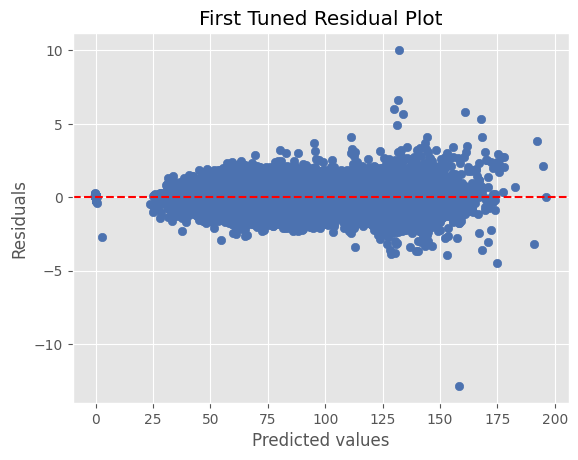

In [313]:
y_pred = first_tuned_model.predict(X_test)
score = np.sqrt(mean_squared_error(y_test**2, y_pred**2))
print("score:", round(score, 2))

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("First Tuned Residual Plot")
plt.show()


##### The residual plot indicates that the variance of the errors is not constant across the predicted values
##### indicating that our model has heteroscedasticity

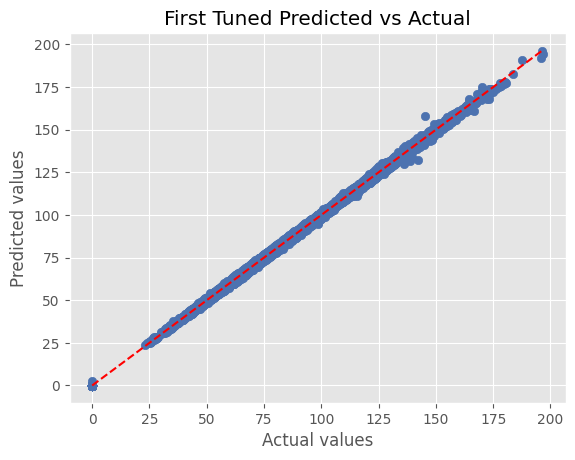

In [314]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("First Tuned Predicted vs Actual")
plt.show()

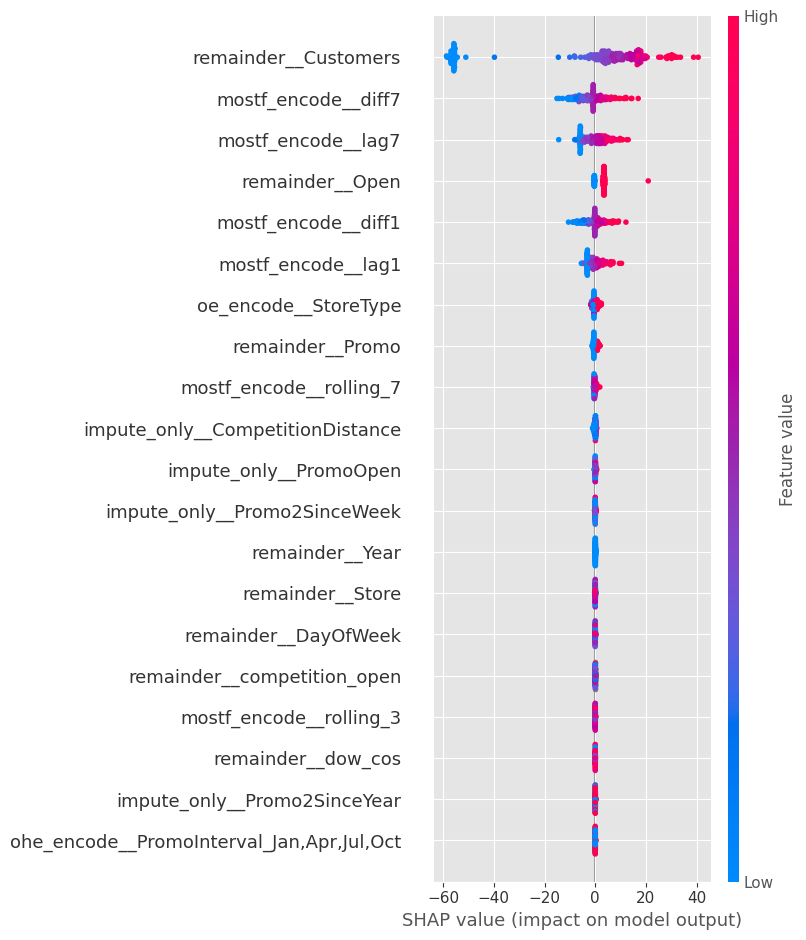

In [315]:
model = first_tuned_model.named_steps["model"]
prep = first_tuned_model.named_steps["prep"]

# SHAP values are per-row contributions, so chronological order doesn’t matter
X_test_sample = X_test.sample(200, random_state=SEED)
feature_names = prep.get_feature_names_out()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(prep.transform(X_test_sample))

shap.summary_plot(shap_values, prep.transform(X_test_sample), feature_names=feature_names)

In [316]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
})

shap_df = shap_df.sort_values("mean_abs_shap", ascending=False)
top_shap_features = shap_df["feature"].head(10).to_list()

top_indices = [list(feature_names).index(f) for f in top_shap_features]

top_indices

[22, 19, 15, 23, 18, 14, 12, 24, 17, 0]

In [317]:
X_train_preprocessed = prep.transform(X_train)
X_test_preprocessed = prep.transform(X_test)

X_train_top = X_train_preprocessed[:, top_indices]
X_test_top = X_test_preprocessed[:, top_indices]


In [ ]:
# DON'T fORGET TO ADD BEST PARAMS FROM MODEL TUNING 
best_paramss = {
    "subsample": 1.0,
    "reg_lambda": 1,
    "reg_alpha": 0,
    "min_child_weight": 10,
    "max_depth": 8,
    "learning_rate": 0.1,
    "gamma": 0.5
}

top_shap_model = xgb.XGBRegressor(**best_paramss, random_state=SEED)

In [ ]:
top_shap_model.fit(X_train_top, y_train)
top_y_pred = top_shap_model.predict(X_test_top)

score = np.sqrt(mean_squared_error(y_test**2, top_y_pred**2))
score